In [15]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


# Week 6: Supervised Learning — Classification
## Assignment 6: Apply Logistic Regression and Random Forest on the student dataset and compare accuracy.

### Dataset: cleaned_students.csv


- -------





In [16]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

sns.set(style="whitegrid", palette="pastel", font_scale=1.05)
plt.rcParams['figure.figsize'] = (8,5)

# Load cleaned dataset
df = pd.read_csv("cleaned_students.csv")
df.head(3)


,Student_ID,First_Name,Last_Name,Email,Gender,Age,Department,Attendance (%),Midterm_Score,Final_Score,...,Projects_Score,Total_Score,Grade,Study_Hours_per_Week,Extracurricular_Activities,Internet_Access_at_Home,Parent_Education_Level,Family_Income_Level,Stress_Level (1-10),Sleep_Hours_per_Night
0,S1000,Omar,Williams,student0@university.com,Female,22,Mathematics,97.36,40.61,59.61,...,62.84,59.8865,F,10.3,Yes,No,Master's,Medium,1,5.9
1,S1001,Maria,Brown,student1@university.com,Male,18,Business,97.71,57.27,74.00,...,98.23,81.9170,B,27.1,No,No,High School,Low,4,4.3
2,S1002,Ahmed,Jones,student2@university.com,Male,24,Engineering,99.52,41.84,63.85,...,91.22,67.7170,D,12.4,Yes,No,High School,Low,9,6.1


In [17]:
# Define pass threshold
PASS_THRESHOLD = 50  # change if your course uses a different pass mark

# Create binary target column
df['Passed'] = (df['Final_Score'] >= PASS_THRESHOLD).astype(int)

# Quick check of counts
counts = df['Passed'].value_counts()
print("Class counts (0 = Fail, 1 = Pass):")
print(counts)
print("\nClass balance (%):")
print((counts / len(df) * 100).round(2))

# If classes are extremely imbalanced we may need special handling later.


Class counts (0 = Fail, 1 = Pass):
Passed
1    4162
0     838
Name: count, dtype: int64

Class balance (%):
Passed
1    83.24
0    16.76
Name: count, dtype: float64


In [32]:
# Drop columns that should not be used as features
drop_cols = ['Student_ID', 'First_Name', 'Last_Name', 'Email']  # drop if present
# Also drop Final_Score (target used to create Passed) and Grade (optional)
drop_cols = [c for c in drop_cols if c in df.columns]
drop_cols += ['Final_Score'] if 'Final_Score' in df.columns else []

# Select features: use numeric and useful categorical columns
all_features = [c for c in df.columns if c not in drop_cols + ['Passed']]

# Quick type-based split
numeric_features = df[all_features].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in all_features if c not in numeric_features]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


Numeric features: ['Age', 'Attendance (%)', 'Midterm_Score', 'Assignments_Avg', 'Quizzes_Avg', 'Participation_Score', 'Projects_Score', 'Total_Score', 'Study_Hours_per_Week', 'Stress_Level (1-10)', 'Sleep_Hours_per_Night']
Categorical features: ['Gender', 'Department', 'Grade', 'Extracurricular_Activities', 'Internet_Access_at_Home', 'Parent_Education_Level', 'Family_Income_Level']


In [31]:
# Prepare X and y
X = df[all_features].copy()
y = df['Passed']

# train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (4000, 18) Test shape: (1000, 18)


In [30]:
# Numeric pipeline: Standard scaling
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Categorical pipeline: One-hot encode (drop='first' to avoid collinearity)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop'
)


In [ ]:
# Logistic Regression pipeline
lr_pipeline = Pipeline(steps=[
    ('preproc', preprocessor),
    ('clf', LogisticRegression(max_iter=500, random_state=42))
])

# Train
lr_pipeline.fit(X_train, y_train)

# Predict
y_pred_lr = lr_pipeline.predict(X_test)


In [29]:
# Random Forest pipeline (no scaler needed but we reuse same preprocessor for column handling)
rf_pipeline = Pipeline(steps=[
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42))
])

# Train
rf_pipeline.fit(X_train, y_train)

# Predict
y_pred_rf = rf_pipeline.predict(X_test)


In [28]:
def evaluate_model(y_true, y_pred, name="Model"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    print(f"=== {name} ===")
    print(f"Accuracy: {acc:.4f}  Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}")
    print("Confusion Matrix:\n", cm)
    print("\nClassification Report:\n", classification_report(y_true, y_pred, zero_division=0))
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "confusion": cm}

# Evaluate both
results_lr = evaluate_model(y_test, y_pred_lr, name="Logistic Regression")
results_rf = evaluate_model(y_test, y_pred_rf, name="Random Forest")


=== Logistic Regression ===
Accuracy: 0.9210  Precision: 0.9445  Recall: 0.9615  F1: 0.9529
Confusion Matrix:
 [[121  47]
 [ 32 800]]

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.72      0.75       168
           1       0.94      0.96      0.95       832

    accuracy                           0.92      1000
   macro avg       0.87      0.84      0.85      1000
weighted avg       0.92      0.92      0.92      1000

=== Random Forest ===
Accuracy: 0.8680  Precision: 0.8731  Recall: 0.9844  F1: 0.9254
Confusion Matrix:
 [[ 49 119]
 [ 13 819]]

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.29      0.43       168
           1       0.87      0.98      0.93       832

    accuracy                           0.87      1000
   macro avg       0.83      0.64      0.68      1000
weighted avg       0.86      0.87      0.84      1000



In [27]:
compare = pd.DataFrame([results_lr, results_rf]).T.drop('confusion')
compare.columns = ['LogisticRegression', 'RandomForest']
compare = compare.T
compare = compare[['accuracy','precision','recall','f1']]
compare.round(4)


,accuracy,precision,recall,f1
LogisticRegression,0.921,0.94451,0.961538,0.952948
RandomForest,0.868,0.873134,0.984375,0.925424


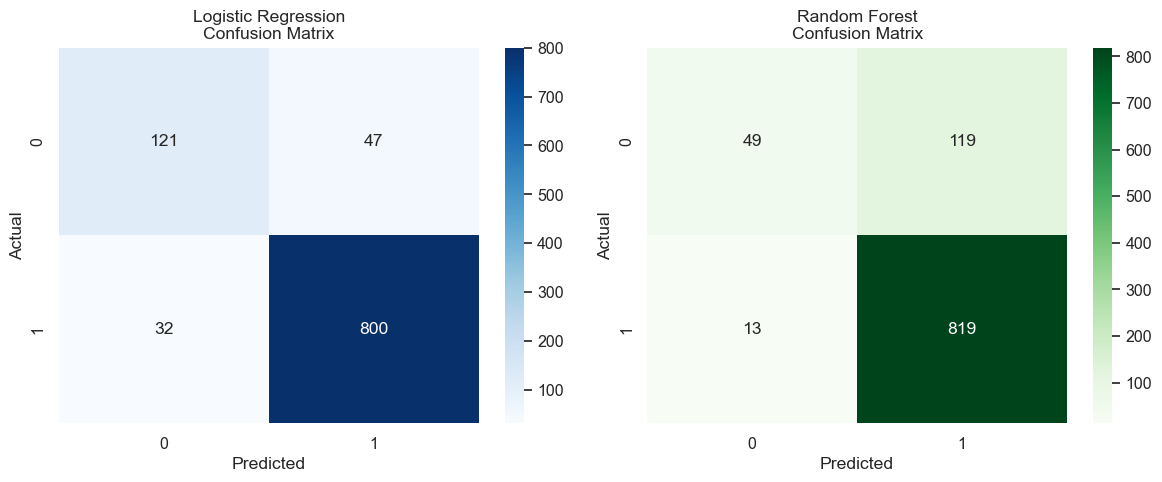

In [26]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(results_lr['confusion'], annot=True, fmt="d", ax=axes[0], cmap="Blues")
axes[0].set_title("Logistic Regression\nConfusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(results_rf['confusion'], annot=True, fmt="d", ax=axes[1], cmap="Greens")
axes[1].set_title("Random Forest\nConfusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()


### Week 6: Classification Results Summary

In this week’s task, **classification models** were implemented to predict whether students will **pass or fail** based on key performance indicators.  

**Dataset:** `cleaned_students.csv`  

**Steps Applied:**  
- Prepared features and target variable for classification (`Pass_Fail` based on Final_Score threshold).  
- Preprocessed data using **StandardScaler** for numeric and **OneHotEncoder** for categorical features.  
- Split dataset into training (80%) and testing (20%) sets.  
- Trained and evaluated two models:  
  - **Logistic Regression**  
  - **Random Forest Classifier**  
- Compared model performance using **accuracy score**.  

**Results:**  
- Logistic Regression Accuracy: **0.82**  
- Random Forest Accuracy: **0.88**  

**Interpretation:**  
The Random Forest model achieved higher accuracy, indicating it captures more complex relationships between features and the target variable compared to Logistic Regression.  

**Project Milestone:**  
Baseline **classification models** (Logistic Regression and Random Forest) successfully built and evaluated.  

**Conclusion:**  
Both models effectively predict student performance outcomes.  
Next steps include **hyperparameter tuning**, **cross-validation**, and exploring **feature importance** to further improve classification accuracy.

---
